In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
sweep_list = ['sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits']

cat = []
for sweep_fn in sweep_list:
    tmp = fitsio.read('/Users/rongpu/Downloads/'+sweep_fn, columns=['GAIA_PHOT_G_MEAN_MAG'])
    idx = np.where(tmp['GAIA_PHOT_G_MEAN_MAG']!=0)[0]
    tmp = fitsio.read('/Users/rongpu/Downloads/'+sweep_fn, rows=idx)
    tmp = Table(tmp)
    cat.append(tmp)
    
cat = vstack(cat)
print(len(cat))

299634


In [4]:
mask = cat['MASKBITS']==0
print(np.sum(mask))
cat = cat[mask]

mask = cat['TYPE']=='PSF '
print(np.sum(mask))
cat = cat[mask]

mask = cat['FRACFLUX_R']<0.1
print(np.sum(mask))
cat = cat[mask]

256746
246825
242940


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])

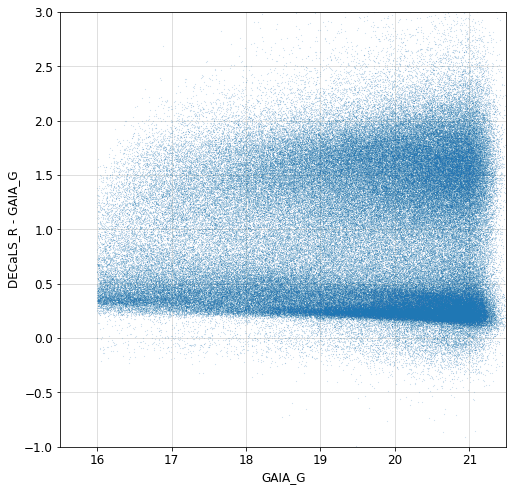

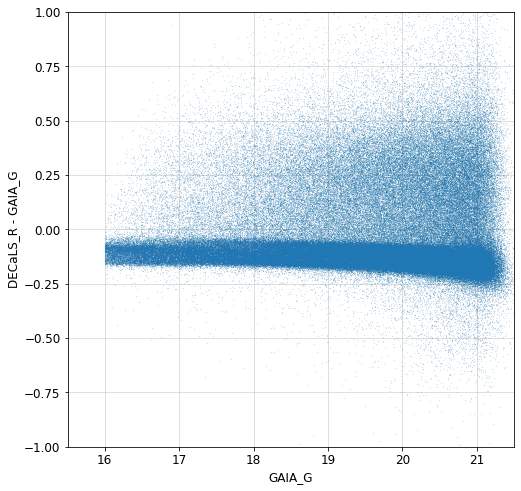

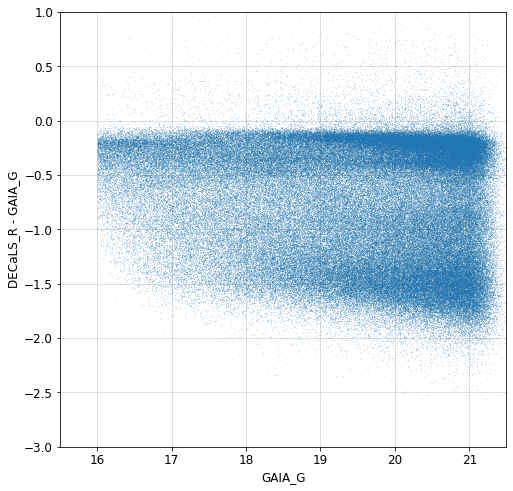

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(cat['GAIA_PHOT_G_MEAN_MAG'], cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'], '.', ms=0.15, alpha=1)
plt.xlabel('GAIA_G')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([15.5, 21.5, -1, 3])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(cat['GAIA_PHOT_G_MEAN_MAG'], cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'], '.', ms=0.15, alpha=1)
plt.xlabel('GAIA_G')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([15.5, 21.5, -1, 1])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(cat['GAIA_PHOT_G_MEAN_MAG'], cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'], '.', ms=0.15, alpha=1)
plt.xlabel('GAIA_G')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([15.5, 21.5, -3, 1])
plt.grid(alpha=0.5)
plt.show()

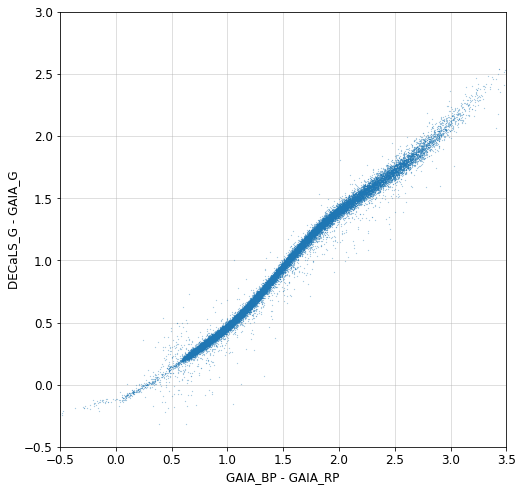

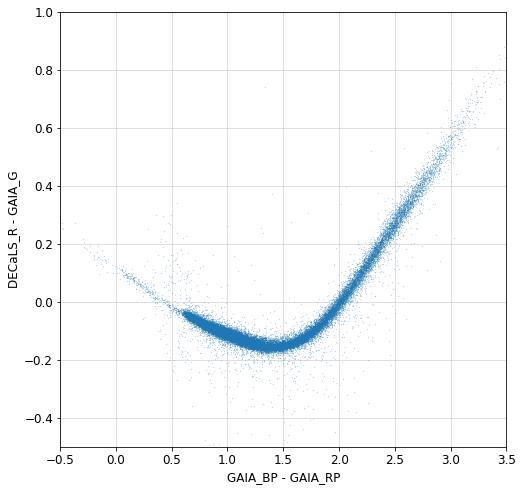

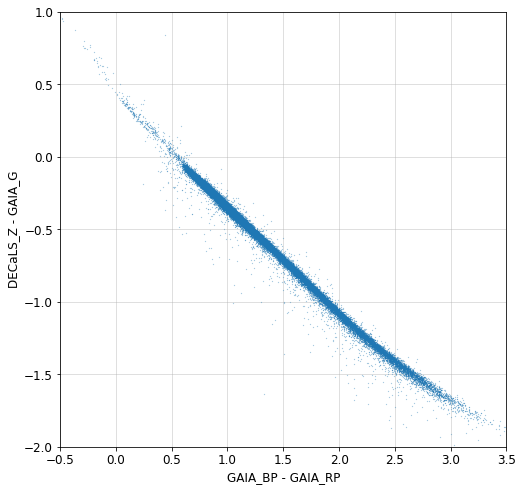

In [7]:
mask = (cat['GAIA_PHOT_G_MEAN_MAG']>16) & ((cat['GAIA_PHOT_G_MEAN_MAG']<18))

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_G - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 3.])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.2)
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 1])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_Z - GAIA_G')
plt.axis([-0.5, 3.5, -2, 1.])
plt.grid(alpha=0.5)
plt.show()

-----
## Interpolate

In [8]:
from scipy.interpolate import interp1d

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_spread = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        if np.sum(mask)>0:
            bin_center[index] = np.median(x[mask])
            bin_median[index] = np.median(y[mask])
            bin_spread[index] = nmad(y[mask])
    return bin_center, bin_median, bin_spread

In [9]:
mask = (cat['GAIA_PHOT_G_MEAN_MAG']>16) & ((cat['GAIA_PHOT_G_MEAN_MAG']<18))

/Users/rongpu/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


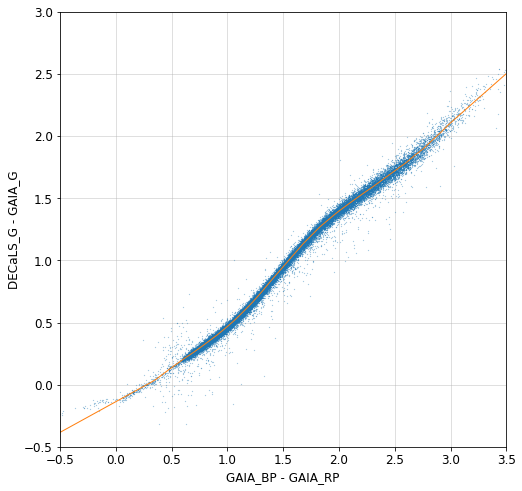

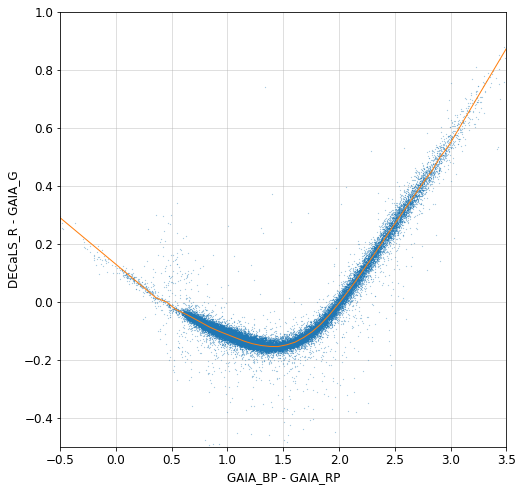

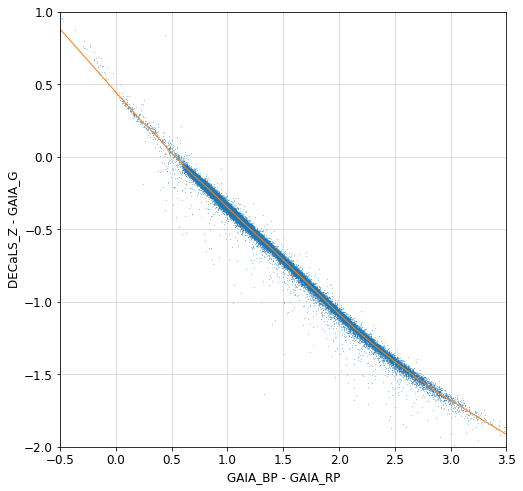

In [10]:
xx = (cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask]
yy = (cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask]
bin_center, bin_median, bin_spread = binned_stats(xx, yy, bins=np.linspace(0.1, 3.1, 40))
np.savez('data/gaia_decals_g_transform.npz', bin_center, bin_median, bin_spread)
transform_interp_g = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')

plt.figure(figsize=(8, 8))
plt.plot(xx, yy, '.', ms=0.3)
# plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, c='C1')
plt.plot(np.sort(xx), transform_interp_g(np.sort(xx)), lw=1, c='C1')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_G - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 3.])
plt.grid(alpha=0.5)
plt.show()

###################################

xx = (cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask]
yy = (cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask]
bin_center, bin_median, bin_spread = binned_stats(xx, yy, bins=np.linspace(0.1, 3.1, 40))
np.savez('data/gaia_decals_r_transform.npz', bin_center, bin_median, bin_spread)
transform_interp_r = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')

plt.figure(figsize=(8, 8))
plt.plot(xx, yy, '.', ms=0.3)
# plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, c='C1')
plt.plot(np.sort(xx), transform_interp_r(np.sort(xx)), lw=1, c='C1')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 1.])
plt.grid(alpha=0.5)
plt.show()

###################################

xx = (cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask]
yy = (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask]
bin_center, bin_median, bin_spread = binned_stats(xx, yy, bins=np.linspace(0.1, 3.1, 40))
np.savez('data/gaia_decals_z_transform.npz', bin_center, bin_median, bin_spread)
transform_interp_z = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')

plt.figure(figsize=(8, 8))
plt.plot(xx, yy, '.', ms=0.3)
# plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, c='C1')
plt.plot(np.sort(xx), transform_interp_z(np.sort(xx)), lw=1, c='C1')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_Z - GAIA_G')
plt.axis([-0.5, 3.5, -2, 1.])
plt.grid(alpha=0.5)
plt.show()